In [ ]:
from google.colab import files
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Upload the file
uploaded = files.upload()

# Assuming the uploaded file's key is the filename, and reading the file into a DataFrame
filename = next(iter(uploaded))
data = pd.read_csv(filename)

# A typical window size for weekly data might be 4 weeks
window_size = 1

# Rename columns for clarity, assuming the columns might need renaming based on the original structure
data.columns = ['Week', 'Cases']

# Normalize the 'Cases' data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Normalized_Cases'] = scaler.fit_transform(data[['Cases']])

# Function to create sequences for LSTM input
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Create the sequences
X, y = create_sequences(data['Normalized_Cases'].values, window_size)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print the shapes of the train and test sets
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


Saving H1N1 cases.csv to H1N1 cases (5).csv
(314, 1) (314,) (79, 1) (79,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming X_train is already reshaped to [samples, time steps, features]
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], 1)),  # 50 LSTM units
    Dropout(0.2),  # Dropout for regularization
    Dense(1)  # Output a single value
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,  # Number of iterations over the entire dataset
    batch_size=32,  # Number of samples per gradient update
    validation_split=0.1,  # Portion of the training data to use as validation
    verbose=1
)


Epoch 1/50
9/9 [==============================] - 4s 180ms/step - loss: 0.0105 - val_loss: 5.3340e-04
Epoch 2/50
9/9 [==============================] - 0s 14ms/step - loss: 0.0099 - val_loss: 0.0012
Epoch 3/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0092 - val_loss: 0.0011
Epoch 4/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0088 - val_loss: 6.8244e-04
Epoch 5/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0088 - val_loss: 5.5787e-04
Epoch 6/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0082 - val_loss: 5.8942e-04
Epoch 7/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0080 - val_loss: 7.3218e-04
Epoch 8/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 6.8280e-04
Epoch 9/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0072 - val_loss: 4.5554e-04
Epoch 10/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0068 - val_loss: 5.2592e-

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Predicting and comparing with actual values
predictions = model.predict(X_test)


3/3 [==============================] - 1s 5ms/step - loss: 0.0054
Test Loss: 0.005409033037722111
3/3 [==============================] - 1s 4ms/step


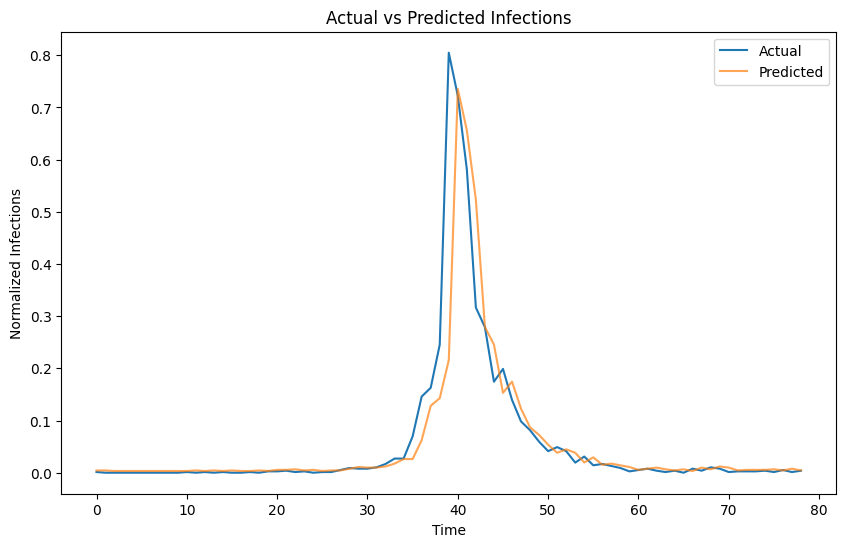

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Infections')
plt.xlabel('Time')
plt.ylabel('Normalized Infections')
plt.legend()
plt.show()


3/3 [==============================] - 0s 4ms/step


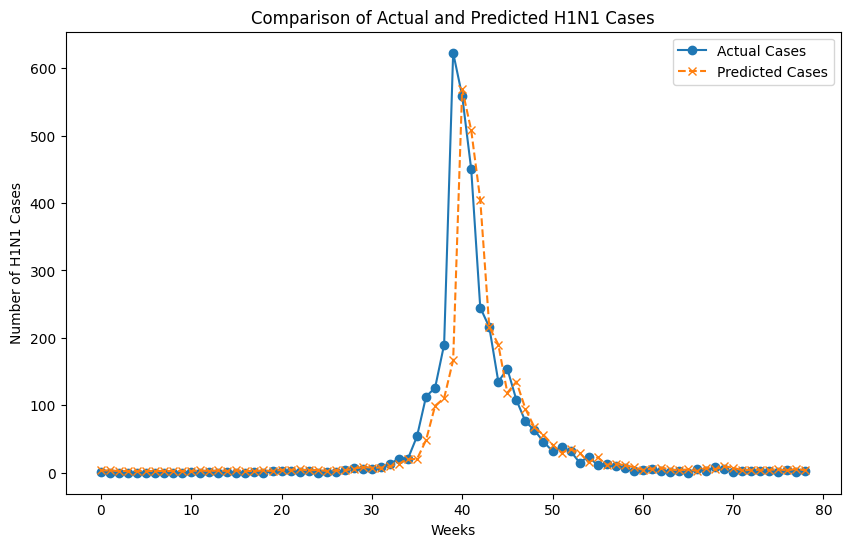

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained LSTM model
# Predict using the test set
predictions_normalized = model.predict(X_test)

# Inverse transform to convert the normalized predictions back to original scale
predictions = scaler.inverse_transform(predictions_normalized)

# Inverse transform the y_test values to original scale for accurate comparison
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Cases', marker='o', linestyle='-')
plt.plot(predictions, label='Predicted Cases', marker='x', linestyle='--')
plt.title('Comparison of Actual and Predicted H1N1 Cases')
plt.xlabel('Weeks')
plt.ylabel('Number of H1N1 Cases')
plt.legend()
plt.show()


3/3 [==============================] - 0s 4ms/step


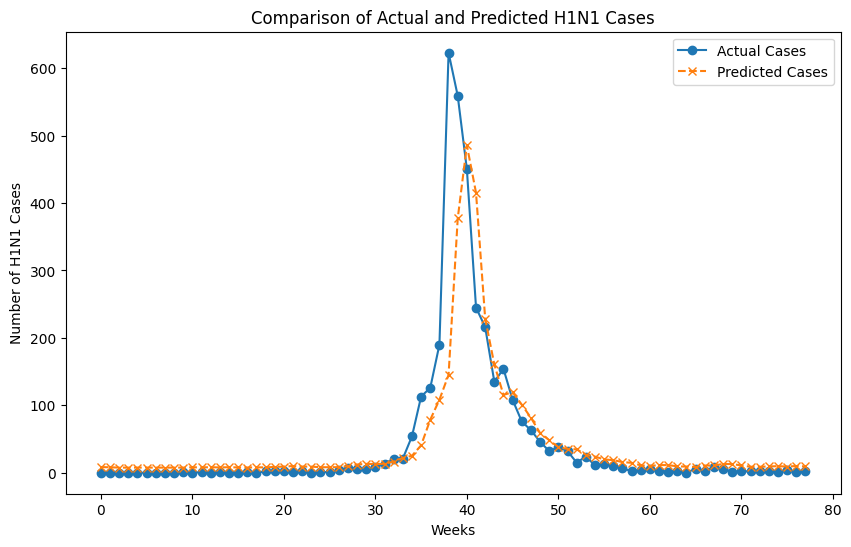

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained LSTM model
# Predict using the test set
predictions_normalized = model.predict(X_test)

# Reshape predictions to match the shape expected by the scaler
predictions_reshaped = predictions_normalized.reshape(-1, 1)

# Inverse transform to convert the normalized predictions back to original scale
predictions = scaler.inverse_transform(predictions_reshaped)

# Also ensure y_test is reshaped appropriately for inverse transformation
y_test_reshaped = y_test.reshape(-1, 1)  # Reshaping y_test to two dimensions
y_test_original = scaler.inverse_transform(y_test_reshaped)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Cases', marker='o', linestyle='-')
plt.plot(predictions, label='Predicted Cases', marker='x', linestyle='--')
plt.title('Comparison of Actual and Predicted H1N1 Cases')
plt.xlabel('Weeks')
plt.ylabel('Number of H1N1 Cases')
plt.legend()
plt.show()


Saving H1N1 cases.csv to H1N1 cases (9).csv
Epoch 1/50
9/9 [==============================] - 3s 73ms/step - loss: 0.0112 - val_loss: 5.1967e-04
Epoch 2/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0011
Epoch 3/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0011
Epoch 4/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0095 - val_loss: 7.9287e-04
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0092 - val_loss: 6.8971e-04
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0086 - val_loss: 6.1782e-04
Epoch 7/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0082 - val_loss: 6.7590e-04
Epoch 8/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 6.1279e-04
Epoch 9/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0077 - val_loss: 7.1247e-04
Epoch 10/50
9/9 [==============================] - 0s 7ms/step 

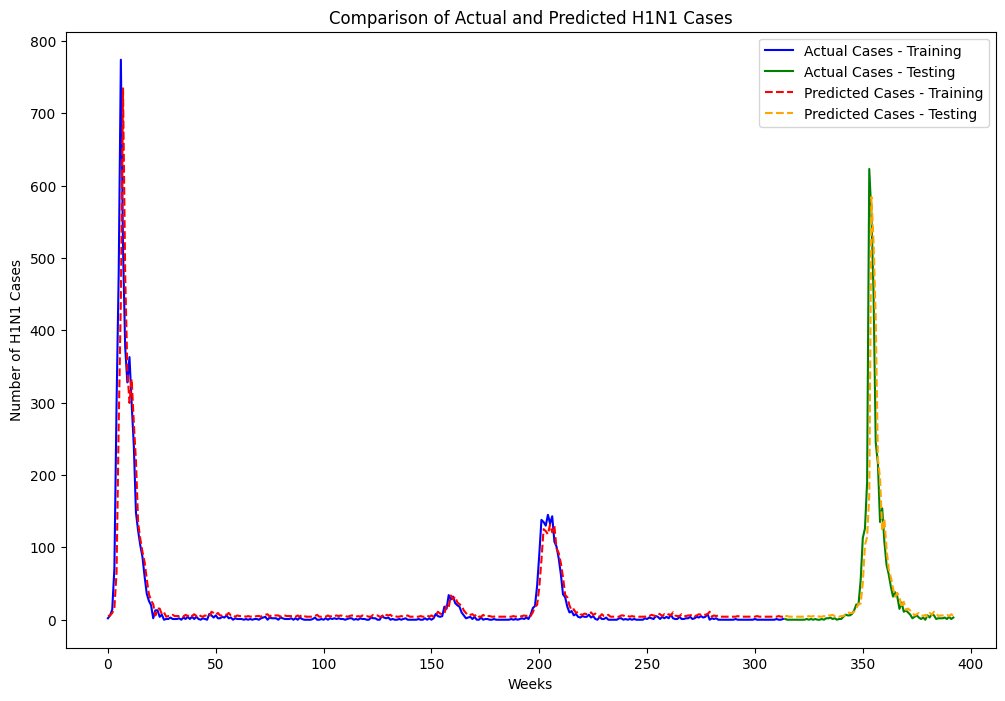

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# Upload and read the dataset
uploaded = files.upload()
filename = next(iter(uploaded))
data = pd.read_csv(filename)

# Renaming columns for clarity
data.columns = ['Week', 'Cases']

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Cases'] = scaler.fit_transform(data[['Cases']])

# Prepare the sequences
window_size = 1

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Generate sequences using the 'Cases' column
X, y = create_sequences(data['Cases'].values, window_size)

# Reshape for LSTM input
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define and compile the LSTM model
model = Sequential([
    LSTM(50, input_shape=(window_size, 1)),  # 50 LSTM units
    Dropout(0.2),  # Dropout to prevent overfitting
    Dense(1)  # Output a single value
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Predict using both train and test set
train_predictions_normalized = model.predict(X_train)
test_predictions_normalized = model.predict(X_test)

# Inverse transform predictions to original scale
train_predictions = scaler.inverse_transform(train_predictions_normalized)
test_predictions = scaler.inverse_transform(test_predictions_normalized)
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(y_train_original, label='Actual Cases - Training', color='blue')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_original, label='Actual Cases - Testing', color='green')
plt.plot(train_predictions, label='Predicted Cases - Training', linestyle='--', color='red')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predictions, label='Predicted Cases - Testing', linestyle='--', color='orange')
plt.title('Comparison of Actual and Predicted H1N1 Cases')
plt.xlabel('Weeks')
plt.ylabel('Number of H1N1 Cases')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming 'test_predictions' and 'y_test_original' are your model's predictions and the actual values, respectively.

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test_original, test_predictions)

# Calculate MSE
mse = mean_squared_error(y_test_original, test_predictions)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R-squared
r2 = r2_score(y_test_original, test_predictions)

# Printing the metrics
print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))
print("Mean Squared Error (MSE): {:.4f}".format(mse))
print("Root Mean Squared Error (RMSE): {:.4f}".format(rmse))
print("R-squared (R²): {:.4f}".format(r2))


Mean Absolute Percentage Error (MAPE): inf%
Mean Squared Error (MSE): 3259.8032
Root Mean Squared Error (RMSE): 57.0947
R-squared (R²): 0.7409


<ipython-input-32-a185e0d3ea2a>:9: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Saving H1N1 cases.csv to H1N1 cases (10).csv
Epoch 1/50
9/9 [==============================] - 1s 36ms/step - loss: 0.0089 - val_loss: 8.6887e-04
Epoch 2/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 5.3660e-04
Epoch 3/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0057 - val_loss: 3.3804e-05
Epoch 4/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0056 - val_loss: 3.8503e-05
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 8.6359e-05
Epoch 6/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0052 - val_loss: 8.7181e-06
Epoch 7/50
9/9 [==============================] - 0s 11ms/step - loss: 0.0053 - val_loss: 2.6096e-06
Epoch 8/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0053 - val_loss: 7.3837e-05
Epoch 9/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0048 - val_loss: 8.4860e-05
Epoch 10/50
9/9 [==============================] -

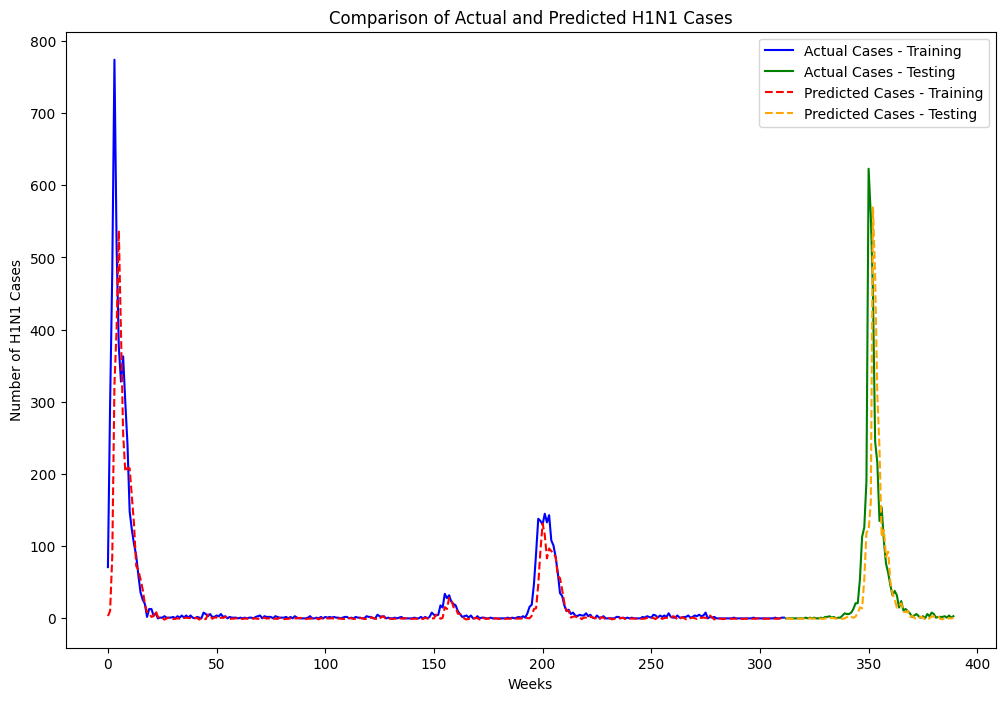

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# Upload and read the dataset
uploaded = files.upload()
filename = next(iter(uploaded))
data = pd.read_csv(filename)

# Renaming columns for clarity
data.columns = ['Week', 'Cases']

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Cases'] = scaler.fit_transform(data[['Cases']])

# Prepare the sequences
window_size = 4

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Generate sequences using the 'Cases' column
X, y = create_sequences(data['Cases'].values, window_size)

# Reshape for 1D CNN input (Conv1D expects 3D input: [samples, timesteps, features])
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define and compile the 1D CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Predict using both train and test set
train_predictions_normalized = model.predict(X_train)
test_predictions_normalized = model.predict(X_test)

# Inverse transform predictions to original scale
train_predictions = scaler.inverse_transform(train_predictions_normalized)
test_predictions = scaler.inverse_transform(test_predictions_normalized)
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(y_train_original, label='Actual Cases - Training', color='blue')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_original, label='Actual Cases - Testing', color='green')
plt.plot(train_predictions, label='Predicted Cases - Training', linestyle='--', color='red')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predictions, label='Predicted Cases - Testing', linestyle='--', color='orange')
plt.title('Comparison of Actual and Predicted H1N1 Cases')
plt.xlabel('Weeks')
plt.ylabel('Number of H1N1 Cases')
plt.legend()
plt.show()


Saving H1N1 cases.csv to H1N1 cases (17).csv
Column names in the dataset: Index(['200923', '1'], dtype='object')


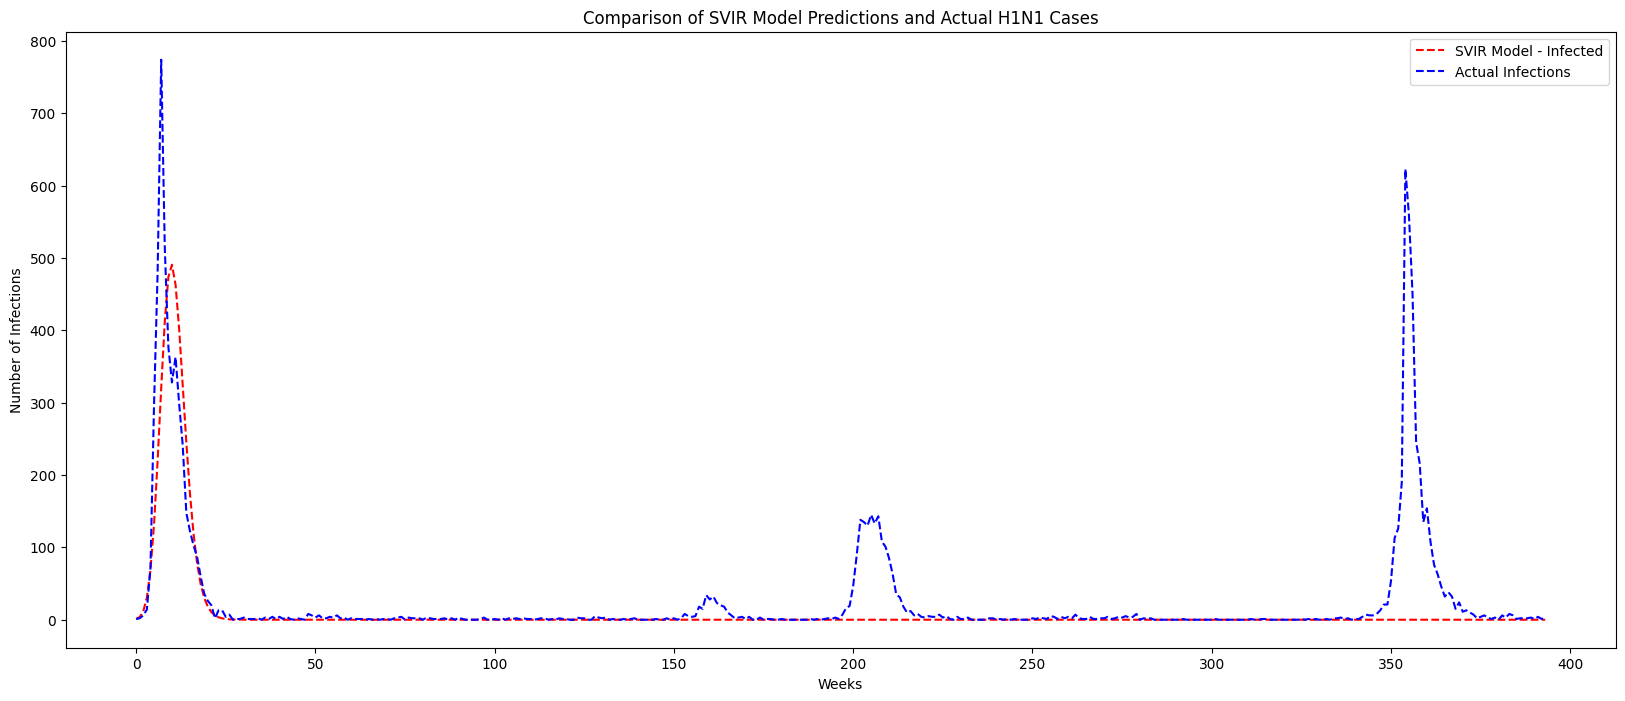

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload and read the dataset
uploaded = files.upload()
filename = next(iter(uploaded))
data = pd.read_csv(filename)

# Print the actual column names
print("Column names in the dataset:", data.columns)

# Constants for the SVIR model
r = 1.17  # Natural recovery rate
N = 42075716  # Total population
gamma = 0.003  # Immunity loss rate
mu = 0.00025  # Death rate
m = 0.0006298  # Birth rate
beta = 2.8  # Infection rate
v = 0.108  # Vaccination rate
xi = 0.3  # Infection rate among vaccinated

# Initial conditions
S0 = N - 1  # All are susceptible except one infected
V0 = 0      # No one is vaccinated initially
I0 = 1      # One initial infected individual
R0 = 0      # No one recovered initially

# Assuming the second column has the infection data and is properly named '1'
actual_infections = data['1'].values
T = len(actual_infections) - 1  # Adjust simulation length to match data length

# Time steps
dt = 1  # One week per time step

# Midpoint Method Implementation
def midpoint_method(f, x0, T, dt):
    n_steps = int(T / dt)
    x = np.zeros((n_steps + 1, 4))
    x[0] = x0
    for i in range(n_steps):
        x_half = x[i] + dt / 2 * f(x[i])
        x[i + 1] = x[i] + dt * f(x_half)
    return x

# SVIR model differential equations
def svir_model(x):
    S, V, I, R = x
    dSdt = m * N - beta * S * I / N + gamma * R - v * S - mu * S
    dVdt = v * S - xi * V * I / N - mu * V
    dIdt = beta * S * I / N + xi * V * I / N - r * I - mu * I
    dRdt = r * I - gamma * R - mu * R
    return np.array([dSdt, dVdt, dIdt, dRdt])

# Simulate the model
initial_conditions = [S0, V0, I0, R0]
result = midpoint_method(svir_model, initial_conditions, T, dt)

# Plotting the results
time = np.arange(0, T + 1)
plt.figure(figsize=(20, 8))
plt.plot(time, result[:, 2], label='SVIR Model - Infected', color='red', linestyle='--')
plt.plot(time, actual_infections, label='Actual Infections', color='blue', linestyle='--')
plt.xlabel('Weeks')
plt.ylabel('Number of Infections')
plt.title('Comparison of SVIR Model Predictions and Actual H1N1 Cases')
plt.legend()
plt.show()


Saving H1N1 cases.csv to H1N1 cases (18).csv
Column names in the dataset: Index(['200923', '1'], dtype='object')


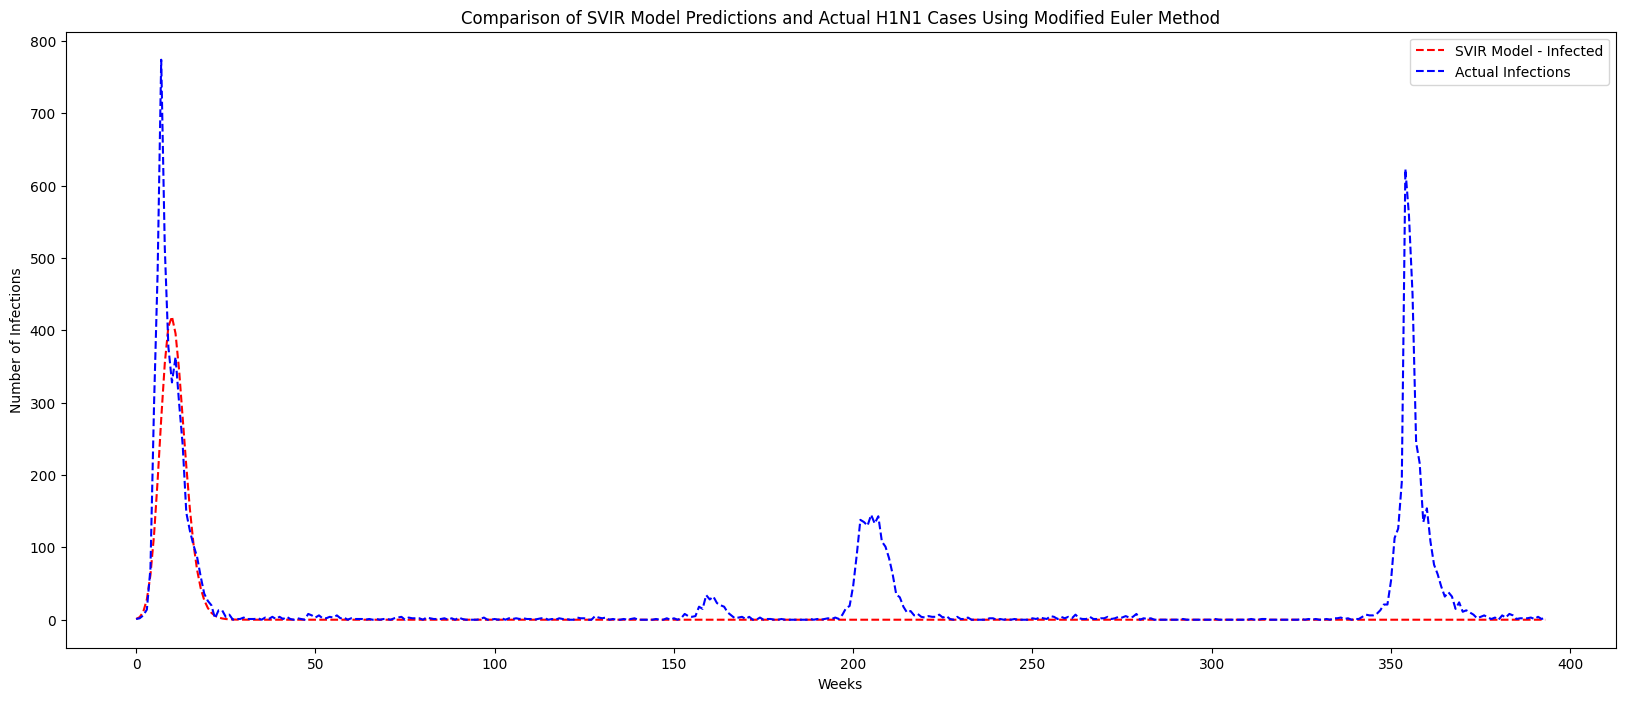

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload and read the dataset
uploaded = files.upload()
filename = next(iter(uploaded))
data = pd.read_csv(filename)

# Print the actual column names
print("Column names in the dataset:", data.columns)

# Constants for the SVIR model
r = 1.17  # Natural recovery rate
N = 42075716  # Total population
gamma = 0.003  # Immunity loss rate
mu = 0.00025  # Death rate
m = 0.0006298  # Birth rate
beta = 2.8  # Infection rate
v = 0.108  # Vaccination rate
xi = 0.3  # Infection rate among vaccinated

# Initial conditions
S0 = N - 1  # All are susceptible except one infected
V0 = 0      # No one is vaccinated initially
I0 = 1      # One initial infected individual
R0 = 0      # No one recovered initially

# Assuming the second column has the infection data and is properly named '1'
actual_infections = data['1'].values
T = len(actual_infections) - 1  # Adjust simulation length to match data length

# Time steps
dt = 1  # One week per time step

# Modified Euler Method Implementation
def modified_euler_method(f, x0, T, dt):
    n_steps = int(T / dt)
    x = np.zeros((n_steps + 1, 4))
    x[0] = x0
    for i in range(n_steps):
        k1 = f(x[i])
        k2 = f(x[i] + dt * k1)
        x[i + 1] = x[i] + (dt / 2) * (k1 + k2)
    return x

# SVIR model differential equations
def svir_model(x):
    S, V, I, R = x
    dSdt = m * N - beta * S * I / N + gamma * R - v * S - mu * S
    dVdt = v * S - xi * V * I / N - mu * V
    dIdt = beta * S * I / N + xi * V * I / N - r * I - mu * I
    dRdt = r * I - gamma * R - mu * R
    return np.array([dSdt, dVdt, dIdt, dRdt])

# Simulate the model using Modified Euler's Method
initial_conditions = [S0, V0, I0, R0]
result = modified_euler_method(svir_model, initial_conditions, T, dt)

# Plotting the results
time = np.arange(0, T + 1)
plt.figure(figsize=(20, 8))
plt.plot(time, result[:, 2], label='SVIR Model - Infected', color='red', linestyle='--')
plt.plot(time, actual_infections, label='Actual Infections', color='blue', linestyle='--')
plt.xlabel('Weeks')
plt.ylabel('Number of Infections')
plt.title('Comparison of SVIR Model Predictions and Actual H1N1 Cases Using Modified Euler Method')
plt.legend()
plt.show()


Saving H1N1 CASES.csv to H1N1 CASES.csv
Epoch 1/50
9/9 [==============================] - 3s 72ms/step - loss: 0.0102 - val_loss: 6.8955e-04
Epoch 2/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0012
Epoch 3/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0011
Epoch 4/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 7.2416e-04
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 5.9492e-04
Epoch 6/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 6.2189e-04
Epoch 7/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 6.0773e-04
Epoch 8/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 6.1562e-04
Epoch 9/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0070 - val_loss: 5.2979e-04
Epoch 10/50
9/9 [==============================] - 0s 6ms/step - lo

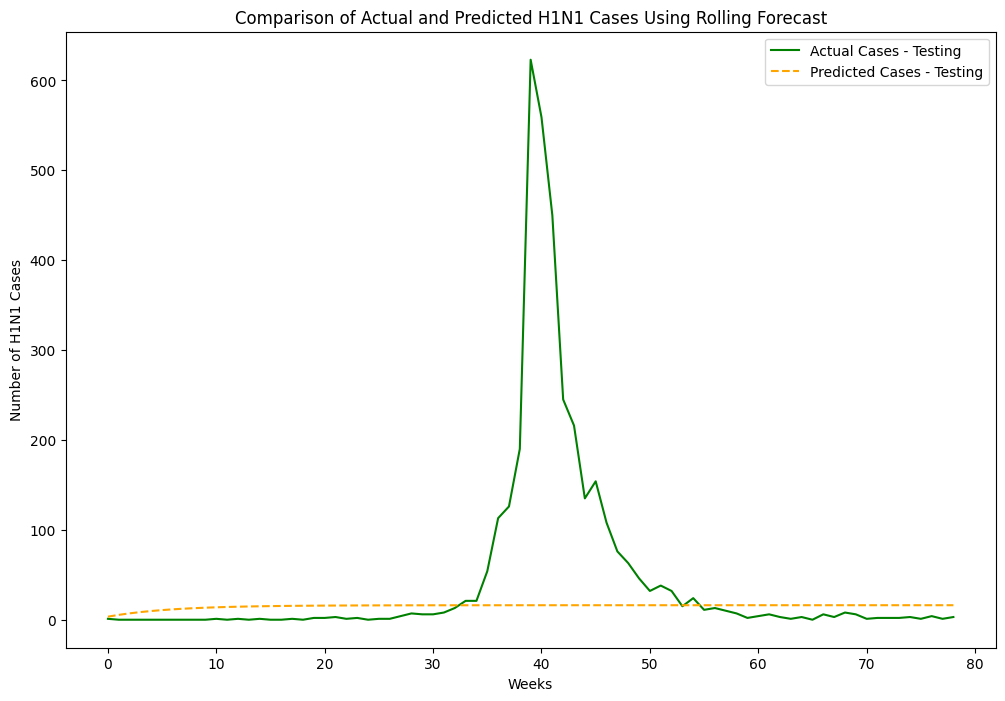

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# Upload and read the dataset
uploaded = files.upload()
filename = next(iter(uploaded))
data = pd.read_csv(filename)

# Renaming columns for clarity
data.columns = ['Week', 'Cases']

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Cases'] = scaler.fit_transform(data[['Cases']])

# Prepare the sequences
window_size = 1

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Generate sequences using the 'Cases' column
X, y = create_sequences(data['Cases'].values, window_size)

# Reshape for LSTM input
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define and compile the LSTM model
model = Sequential([
    LSTM(50, input_shape=(window_size, 1)),  # 50 LSTM units
    Dropout(0.2),  # Dropout to prevent overfitting
    Dense(1)  # Output a single value
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Rolling forecast
test_predictions = []
last_x = X_test[0]  # Starting point for rolling forecast

for i in range(len(X_test)):
    pred = model.predict(last_x.reshape(1, window_size, 1))  # Make prediction with the last observed data point
    test_predictions.append(pred[0,0])  # Store prediction
    last_x = np.roll(last_x, -1)  # Shift window
    last_x[-1] = pred  # Insert the prediction at the end of the window

# Inverse transform predictions to original scale
test_predictions = np.array(test_predictions)
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(y_test_original, label='Actual Cases - Testing', color='green')
plt.plot(test_predictions, label='Predicted Cases - Testing', linestyle='--', color='orange')
plt.title('Comparison of Actual and Predicted H1N1 Cases Using Rolling Forecast')
plt.xlabel('Weeks')
plt.ylabel('Number of H1N1 Cases')
plt.legend()
plt.show()


Saving H1N1 CASES.csv to H1N1 CASES (1).csv
Epoch 1/50
9/9 [==============================] - 4s 66ms/step - loss: 0.0113 - val_loss: 5.2309e-04
Epoch 2/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0012
Epoch 3/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0012
Epoch 4/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 8.0475e-04
Epoch 5/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 6.7504e-04
Epoch 6/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 5.9380e-04
Epoch 7/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 5.9571e-04
Epoch 8/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0085 - val_loss: 7.5264e-04
Epoch 9/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0079 - val_loss: 6.3982e-04
Epoch 10/50
9/9 [==============================] - 0s 6ms/step 

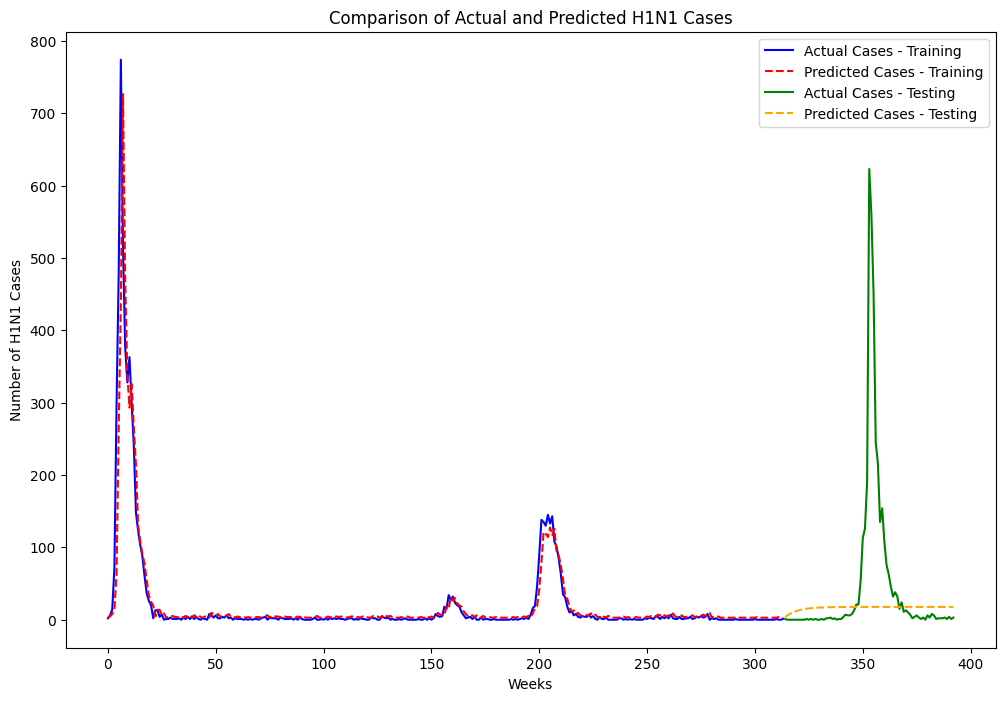

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# Upload and read the dataset
uploaded = files.upload()
filename = next(iter(uploaded))
data = pd.read_csv(filename)

# Renaming columns for clarity
data.columns = ['Week', 'Cases']

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Cases'] = scaler.fit_transform(data[['Cases']])

# Prepare the sequences
window_size = 1

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Generate sequences using the 'Cases' column
X, y = create_sequences(data['Cases'].values, window_size)

# Reshape for LSTM input
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define and compile the LSTM model
model = Sequential([
    LSTM(50, input_shape=(window_size, 1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Predict using both train and test set
train_predictions_normalized = model.predict(X_train)
test_predictions_normalized = []

# Rolling forecast for the test data
last_x = X_test[0]
for i in range(len(X_test)):
    pred = model.predict(last_x.reshape(1, window_size, 1))
    test_predictions_normalized.append(pred[0, 0])
    last_x = np.roll(last_x, -1)
    last_x[-1] = pred

# Convert all predictions back to the original scale
train_predictions = scaler.inverse_transform(train_predictions_normalized)
test_predictions = scaler.inverse_transform(np.array(test_predictions_normalized).reshape(-1, 1))
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(y_train_original)), y_train_original, label='Actual Cases - Training', color='blue')
plt.plot(np.arange(len(y_train_original)), train_predictions, label='Predicted Cases - Training', linestyle='--', color='red')
plt.plot(np.arange(len(y_train_original), len(y_train_original) + len(y_test_original)), y_test_original, label='Actual Cases - Testing', color='green')
plt.plot(np.arange(len(y_train_original), len(y_train_original) + len(y_test_original)), test_predictions, label='Predicted Cases - Testing', linestyle='--', color='orange')
plt.title('Comparison of Actual and Predicted H1N1 Cases')
plt.xlabel('Weeks')
plt.ylabel('Number of H1N1 Cases')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error

# Assuming 'train_predictions' and 'test_predictions' contain the predicted values from your LSTM,
# and 'y_train_original' and 'y_test_original' contain the actual values.

# Calculate MAE for the training set
mae_train = mean_absolute_error(y_train_original, train_predictions)
# Calculate MAE for the testing set
mae_test = mean_absolute_error(y_test_original, test_predictions)

# Output the calculated MAEs
print("Training Mean Absolute Error:", mae_train)
print("Testing Mean Absolute Error:", mae_test)


Training Mean Absolute Error: 8.169581785323514
Testing Mean Absolute Error: 47.02209737632848
